In [1]:
import os
import pickle
import pandas as pd
import seaborn as sns
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
%matplotlib inline 

In [2]:
DATA_DIR = Path('../data/raw')
INTERIM_DIR = DATA_DIR.parent / 'interim'
PROCESSED_DIR = DATA_DIR.parent / 'processed'
! ls $DATA_DIR

Pearl Challenge data with dictionary_For_Share_v4.xlsx


# Training Data

In [3]:
pearl_data_xls = pd.read_excel(str(DATA_DIR / 'Pearl Challenge data with dictionary_For_Share_v4.xlsx'), sheet_name=['TrainData', 'TestData'])

pearl_train_df = pearl_data_xls['TrainData']
pearl_train_df.head(2)

,FarmerID,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,Ownership,No_of_Active_Loan_In_Bureau,Avg_Disbursement_Amount_Bureau,Non_Agriculture_Income,Total_Land_For_Agriculture,"K022-Village category based on Agri parameters (Good, Average, Poor)",K022-Nearest Mandi Name,K022-Proximity to nearest mandi (Km),K022-Proximity to nearest railway (Km),KO22-Village score based on socio-economic parameters (0 to 100),"K022-Village category based on socio-economic parameters (Good, Average, Poor)",K022-Seasonal Average Rainfall (mm),K022-Ambient temperature (min & max),"R022-Village category based on Agri parameters (Good, Average, Poor)",R022-Seasonal Average Rainfall (mm),R022-Ambient temperature (min & max),K021-Seasonal Average Rainfall (mm),K021-Ambient temperature (min & max),R021-Seasonal Average Rainfall (mm),R021-Ambient temperature (min & max),R020-Seasonal Average Rainfall (mm),R020-Ambient temperature (min & max),Perc_of_house_with_6plus_room,Women_15_19_Mothers_or_Pregnant_at_time_of_survey,perc_of_pop_living_in_hh_electricity,perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms,mat_roof_Metal_GI_Asbestos_sheets,perc_of_Wall_material_with_Burnt_brick,Households_with_improved_Sanitation_Facility,perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k,K022-Total Geographical Area (in Hectares)-,K022-Net Agri area (in Ha)-,K022-Net Agri area (% of total geog area)-,Kharif Seasons Irrigated area in 2022,Kharif Seasons Cropping density in 2022,Kharif Seasons Agricultural performance in 2022,Kharif Seasons Agricultural Score in 2022,Kharif Seasons Type of soil in 2022,Kharif Seasons Type of water bodies in hectares 2022,Kharif Seasons Agro Ecological Sub Zone in 2022,Kharif Seasons Seasonal average groundwater thickness (cm) in 2022,Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2022,Rabi Seasons Season Irrigated area in 2022,Rabi Seasons Cropping density in 2022,Rabi Seasons Agricultural performance in 2022,Rabi Seasons Agricultural Score in 2022,Rabi Seasons Type of soil in 2022,Rabi Seasons Type of water bodies in hectares 2022,Rabi Seasons Agro Ecological Sub Zone in 2022,Rabi Seasons Seasonal average groundwater thickness (cm) in 2022,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022,Rabi Seasons Kharif Season Irrigated area in 2021,Rabi Seasons Cropping density in 2021,Rabi Seasons Agricultural performance in 2021,Rabi Seasons Agricultural Score in 2021,Rabi Seasons Type of soil in 2021,Rabi Seasons Type of water bodies in hectares 2021,Rabi Seasons Agro Ecological Sub Zone in 2021,Rabi Seasons Seasonal average groundwater thickness (cm) in 2021,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021,Kharif Seasons Kharif Season Irrigated area in 2021,Kharif Seasons Cropping density in 2021,Kharif Seasons Agricultural performance in 2021,Kharif Seasons Agricultural Score in 2021,Kharif Seasons Type of soil in 2021,Kharif Seasons Type of water bodies in hectares 2021,Kharif Seasons Agro Ecological Sub Zone in 2021,Kharif Seasons Seasonal average groundwater thickness (cm) in 2021,Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021,Kharif Seasons Kharif Season Irrigated area in 2020,Kharif Seasons Cropping density in 2020,Kharif Seasons Agricultural performance in 2020,Kharif Seasons Agricultural Score in 2020,Kharif Seasons Type of soil in 2020,Kharif Seasons Type of water bodies in hectares 2020,Kharif Seasons Agro Ecological Sub Zone in 2020,Kharif Seasons Seasonal average groundwater thickness (cm) in 2020,Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Rabi Seasons Kharif Season Irrigated area in 2020,Rabi Seasons Cropping density in 2020,Rabi Seasons Agricultural performance in 2020,Rabi Seasons Agricultural Score in 2020,Rabi Seasons Type of soil in 2020,Rabi Seasons Type of water bodies in hectares 2020,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi 

In [4]:
pearl_train_df.rename(
    columns={
        ' Night light index': 'Night light index',
        ' Village category based on socio-economic parameters (Good, Average, Poor)': 'Village category based on socio-economic parameters (Good, Average, Poor)',
        ' Village score based on socio-economic parameters (Non normalised)': 'Village score based on socio-economic parameters (Non normalised)',
        ' Village score based on socio-economic parameters (0 to 100)': 'Village score based on socio-economic parameters (0 to 100)',
        ' Land Holding Index source (Total Agri Area/ no of people)': 'Land Holding Index source (Total Agri Area/ no of people)',
        ' Road density (Km/ SqKm)': 'Road density (Km/ SqKm)'
    }
, inplace=True)

## Duplicate FarmerIDs

In [5]:
print(f"Train Data Shape: {pearl_train_df.shape}")
print(f"Unique FarmerID: {pearl_train_df['FarmerID'].nunique()}")

Train Data Shape: (53306, 105)
Unique FarmerID: 53279


In [6]:
pearl_train_df = pearl_train_df.drop_duplicates(subset=['FarmerID']).reset_index(drop=True)
print(f"Train Data Shape: {pearl_train_df.shape}")
print(f"Unique FarmerID: {pearl_train_df['FarmerID'].nunique()}")

Train Data Shape: (53279, 105)
Unique FarmerID: 53279


## Outlier Removal

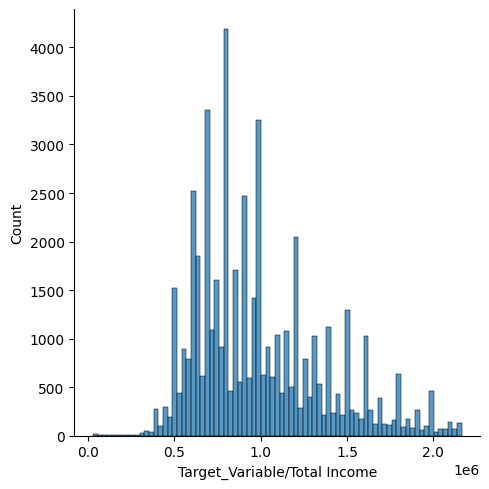

In [7]:
to_filter=True

if to_filter:
    Q1 = pearl_train_df['Target_Variable/Total Income'].quantile(0.25)
    Q3 = pearl_train_df['Target_Variable/Total Income'].quantile(0.75)
    IQR = Q3 - Q1
    
    
    pearl_train_df = pearl_train_df[
        ~((pearl_train_df['Target_Variable/Total Income'] < 100) |\
          (pearl_train_df['Target_Variable/Total Income'] > (Q3 + 1.5 * IQR)))]

sns.displot(data=pearl_train_df, x='Target_Variable/Total Income')
plt.show()

In [8]:
pearl_train_df.shape

(50252, 105)

In [9]:
pearl_train_df.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Index: 50252 entries, 0 to 53278
Data columns (total 105 columns):
 #    Column                                                                          Non-Null Count  Dtype  
---   ------                                                                          --------------  -----  
 0    FarmerID                                                                        50252 non-null  int64  
 1    State                                                                           50252 non-null  object 
 2    REGION                                                                          50252 non-null  object 
 3    SEX                                                                             50252 non-null  object 
 4    CITY                                                                            50252 non-null  object 
 5    Zipcode                                                                         50252 non-null  int64  
 6    DISTRICT 

## Float Columns

__Features:__
- YoY Features
    - Cropping Density
    - Agricultural Performance
    - Agricultural Score
    - Irrigated Area
    - Ground water thickness
    - Ground water replenishment
    - Average Rainfall



### Data Cleaning
- Column: `Village score based on socio-economic parameters (0 to 100)` and `KO22-Village score based on socio-economic parameters (0 to 100)` are duplicate columns. Clubbing both in one column as `village_socio_economic_score`
- __Cropping Density:__
    - Rabi season of 2022 and Kharif season of 2021 have same values
    - Rabi season of 2021 and Kharif season of 2020 have same values
- __Agricultural Performance__
    - All columns seems right. They all have seperate values. Different combinations of feature can be utilized during training. For year 2022, either seperate columns for Rabi and Kharif seasons of mean value of Rabi and Kharif can be experimented during training.
- __Agricultural Score__
    - Agriculture score and performance have positive correlation in there corresponding year and season. Same feature engineering experiment can be done as done on agricultural performance
- __Irrigated Area__
    - Rabi season of 2022 and Kharif season of 2021 have same values
    - Rabi season of 2021 and Kharif season of 2020 have same values
- __Ground Water Thickness__
    - All season and year values are different and can be used for training
- __Ground Water Replenishment__
    - All season and year values are different and can be used for training
- __Average Rainfall__
    - All season and year values are different and can be used for training
- __Avg_Disbursement_Amount_Bureau:__
    - Impute nan values with zero, as those reocrds are for farmers having zero active loans

In [10]:
float_train_to_drop_columns = [
    'FarmerID',
    'Village score based on socio-economic parameters (Non normalised)',
]

float_train_columns = [
    'FarmerID',
    'Avg_Disbursement_Amount_Bureau',
    'Total_Land_For_Agriculture',
    'K022-Proximity to nearest mandi (Km)',
    'K022-Proximity to nearest railway (Km)',
    'KO22-Village score based on socio-economic parameters (0 to 100)',
    'K022-Seasonal Average Rainfall (mm)',
    'R022-Seasonal Average Rainfall (mm)',
    'K021-Seasonal Average Rainfall (mm)',
    'R021-Seasonal Average Rainfall (mm)',
    'R020-Seasonal Average Rainfall (mm)', # K020-Seasonal Average Rainfall (mm) not available
    'Perc_of_house_with_6plus_room',
    'Women_15_19_Mothers_or_Pregnant_at_time_of_survey',
    'perc_of_pop_living_in_hh_electricity',
    'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms',
    'mat_roof_Metal_GI_Asbestos_sheets',
    'perc_of_Wall_material_with_Burnt_brick',
    'Households_with_improved_Sanitation_Facility',
    'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k',
    'K022-Total Geographical Area (in Hectares)-',
    'K022-Net Agri area (in Ha)-',
    'K022-Net Agri area (% of total geog area)-',
    'Kharif Seasons  Irrigated area in 2022',
    'Kharif Seasons  Cropping density in 2022',
    'Kharif Seasons  Agricultural performance in 2022',
    'Kharif Seasons  Agricultural Score in 2022',
    'Kharif Seasons  Seasonal average groundwater thickness (cm) in 2022',
    'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022',
    'Rabi Seasons  Season Irrigated area in 2022',
    'Rabi Seasons Cropping density in 2022',
    'Rabi Seasons Agricultural performance in 2022',
    'Rabi Seasons Agricultural Score in 2022',
    'Rabi Seasons Seasonal average groundwater thickness (cm) in 2022',
    'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022',
    'Rabi Seasons Kharif Season Irrigated area in 2021',
    'Rabi Seasons Cropping density in 2021',
    'Rabi Seasons Agricultural performance in 2021',
    'Rabi Seasons Agricultural Score in 2021',
    'Rabi Seasons Seasonal average groundwater thickness (cm) in 2021',
    'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021',
    'Kharif Seasons Kharif Season Irrigated area in 2021',
    'Kharif Seasons Cropping density in 2021',
    'Kharif Seasons Agricultural performance in 2021',
    'Kharif Seasons Agricultural Score in 2021',
    'Kharif Seasons Seasonal average groundwater thickness (cm) in 2021',
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021',
    'Kharif Seasons Kharif Season Irrigated area in 2020',
    'Kharif Seasons Cropping density in 2020',
    'Kharif Seasons Agricultural performance in 2020',
    'Kharif Seasons Agricultural Score in 2020',
    'Kharif Seasons Seasonal average groundwater thickness (cm) in 2020',
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020',
    'Rabi Seasons Kharif Season Irrigated area in 2020',
    'Rabi Seasons Cropping density in 2020',
    'Rabi Seasons Agricultural performance in 2020',
    'Rabi Seasons Agricultural Score in 2020',
    'Rabi Seasons Seasonal average groundwater thickness (cm) in 2020',
    'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020',
    'Night light index',
    'Village score based on socio-economic parameters (0 to 100)',
    'Land Holding Index source (Total Agri Area/ no of people)',
    'Road density (Km/ SqKm)'
]

### Average Disbursement Amount Bureau

### NaN values

In [11]:
pearl_train_df = pearl_train_df.fillna({'Avg_Disbursement_Amount_Bureau': 0})

In [12]:
pearl_train_df = pearl_train_df.dropna(
    subset=[
        'Perc_of_house_with_6plus_room',
        'Women_15_19_Mothers_or_Pregnant_at_time_of_survey',
        'perc_of_pop_living_in_hh_electricity',
        'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms',
        'mat_roof_Metal_GI_Asbestos_sheets',
        'perc_of_Wall_material_with_Burnt_brick',
        'Households_with_improved_Sanitation_Facility',
        'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k'
    ]
)

In [13]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Avg_Disbursement_Amount_Bureau': 'avg_disbursement_amount_bureau'
    }
)

In [81]:
pearl_train_df.shape

(50081, 165)

### Cropping Density 

In [14]:
pearl_train_df['cropping_density_kharif_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons  Cropping density in 2022'] - x['Kharif Seasons Cropping density in 2021']) / (x['Kharif Seasons  Cropping density in 2022'] + 1e-5), 
    axis=1
)

pearl_train_df['cropping_density_rabi_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Cropping density in 2022'] - x['Rabi Seasons Cropping density in 2021']) / (x['Rabi Seasons Cropping density in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['cropping_density_kharif_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons Cropping density in 2021'] - x['Kharif Seasons Cropping density in 2020']) / (x['Kharif Seasons Cropping density in 2021'] + 1e-5),
    axis=1
)

pearl_train_df['cropping_density_rabi_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Cropping density in 2021'] - x['Rabi Seasons Cropping density in 2020']) / (x['Rabi Seasons Cropping density in 2021'] + 1e-5),
    axis=1
)

In [15]:
# Cropping Density Processing
pearl_train_df = pearl_train_df.rename(
    columns={
        'Kharif Seasons  Cropping density in 2022': 'kharif_seasons_cropping_density_2022',
        'Rabi Seasons Cropping density in 2022': 'rabi_seasons_cropping_density_2022',
        
    }
)

In [16]:
feature_columns_cropping_density = [
    'cropping_density_kharif_2022_2021_growth',
    'cropping_density_rabi_2022_2021_growth',
    'cropping_density_kharif_2021_2020_growth',
    'cropping_density_rabi_2021_2020_growth',
    'kharif_seasons_cropping_density_2022',
    'rabi_seasons_cropping_density_2022'
]

In [17]:
# # Cropping density
# "Kharif Seasons  Cropping density in 2022",	
# "Rabi Seasons Cropping density in 2022",	
# "Rabi Seasons Cropping density in 2021",	
# "Kharif Seasons Cropping density in 2021",	
# "Kharif Seasons Cropping density in 2020",	
# "Rabi Seasons Cropping density in 2020"

# pearl_train_df[["Rabi Seasons Cropping density in 2021", "Rabi Seasons Cropping density in 2020"]].mean(axis=1)

### Agricultural Performance

In [18]:
pearl_train_df['kharif_season_agricultural_performance_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons  Agricultural performance in 2022'] - x['Kharif Seasons Agricultural performance in 2021']) / (x['Kharif Seasons  Agricultural performance in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_agricultural_performance_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Agricultural performance in 2022'] - x['Rabi Seasons Agricultural performance in 2021']) / (x['Rabi Seasons Agricultural performance in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['kharif_season_agricultural_performance_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons Agricultural performance in 2021'] - x['Kharif Seasons Agricultural performance in 2020']) / (x['Kharif Seasons Agricultural performance in 2021'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_agricultural_performance_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Agricultural performance in 2021'] - x['Rabi Seasons Agricultural performance in 2020']) / (x['Rabi Seasons Agricultural performance in 2021'] + 1e-5),
    axis=1
)

In [19]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Kharif Seasons  Agricultural performance in 2022': 'kharif_seasons_agricultural_performance_2022',
        'Rabi Seasons Agricultural performance in 2022': 'rabi_seasons_agricultural_performance_2022'
    }
)

# pearl_train_df['kharif_recency_agricultural_performeance'] = pearl_train_df[[
#     "Kharif Seasons Agricultural performance in 2021",
#     "Kharif Seasons Agricultural performance in 2020"
# ]].mean(axis=1)

# pearl_train_df['rabi_recency_agricultural_performance'] = pearl_train_df[[
#     "Rabi Seasons Agricultural performance in 2021",
#     "Rabi Seasons Agricultural performance in 2020"
# ]].mean(axis=1)


# Agriculture Performance
# "Kharif Seasons  Agricultural performance in 2022",	
# "Rabi Seasons Agricultural performance in 2022",	
# "Rabi Seasons Agricultural performance in 2021",	
# "Kharif Seasons Agricultural performance in 2021",	
# "Kharif Seasons Agricultural performance in 2020",	
# "Rabi Seasons Agricultural performance in 2020"

In [20]:
feature_columns_agriculture_performance = [
    'kharif_season_agricultural_performance_2022_2021_growth',
    'rabi_season_agricultural_performance_2022_2021_growth',
    'kharif_season_agricultural_performance_2021_2020_growth',
    'rabi_season_agricultural_performance_2021_2020_growth',
    'kharif_seasons_agricultural_performance_2022',
    'rabi_seasons_agricultural_performance_2022'
]

### Agricultural Score

In [21]:
pearl_train_df['kharif_season_agriculture_score_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons  Agricultural Score in 2022'] - x['Kharif Seasons Agricultural Score in 2021']) - (x['Kharif Seasons  Agricultural Score in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_agriculture_score_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Agricultural Score in 2022'] - x['Rabi Seasons Agricultural Score in 2021']) - (x['Rabi Seasons Agricultural Score in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['kharif_season_agriculture_score_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons Agricultural Score in 2021'] - x['Kharif Seasons Agricultural Score in 2020']) - (x['Kharif Seasons Agricultural Score in 2021'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_agriculture_score_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Agricultural Score in 2021'] - x['Rabi Seasons Agricultural Score in 2020']) - (x['Rabi Seasons Agricultural Score in 2021'] + 1e-5),
    axis=1
)


In [22]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Kharif Seasons  Agricultural Score in 2022': 'kharif_seasons_agricultural_score_2022',
        'Rabi Seasons Agricultural Score in 2022': 'rabi_seasons_agricultiral_score_2022'
    }
)

# pearl_train_df['kharif_recency_agricultural_score'] = pearl_train_df[[
#     "Kharif Seasons Agricultural Score in 2021",
#     "Kharif Seasons Agricultural Score in 2020"
# ]].mean(axis=1)

# pearl_train_df['rabi_recency_agricultural_score'] = pearl_train_df[[
#     "Rabi Seasons Agricultural Score in 2021",
#     "Rabi Seasons Agricultural Score in 2020"
# ]].mean(axis=1)


# "Kharif Seasons  Agricultural Score in 2022",	
# "Rabi Seasons Agricultural Score in 2022",	
# "Rabi Seasons Agricultural Score in 2021",	
# "Kharif Seasons Agricultural Score in 2021",	
# "Kharif Seasons Agricultural Score in 2020",	
# "Rabi Seasons Agricultural Score in 2020"

In [23]:
feature_columns_agriculture_score = [
    'kharif_season_agriculture_score_2022_2021_growth',
    'rabi_season_agriculture_score_2022_2021_growth',
    'kharif_season_agriculture_score_2021_2020_growth',
    'rabi_season_agriculture_score_2021_2020_growth',
    'kharif_seasons_agricultural_score_2022',
    'rabi_seasons_agricultiral_score_2022'
]

### Irrigated Area

In [24]:
pearl_train_df['kharif_season_irrigated_area_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons  Irrigated area in 2022'] - x['Kharif Seasons Kharif Season Irrigated area in 2021']) - (x['Kharif Seasons  Irrigated area in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_irrigated_area_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons  Season Irrigated area in 2022'] - x['Rabi Seasons Kharif Season Irrigated area in 2021']) - (x['Rabi Seasons  Season Irrigated area in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['kharif_season_irrigated_area_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons Kharif Season Irrigated area in 2021'] - x['Kharif Seasons Kharif Season Irrigated area in 2020']) - (x['Kharif Seasons Kharif Season Irrigated area in 2021'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_irrigated_area_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Kharif Season Irrigated area in 2021'] - x['Rabi Seasons Kharif Season Irrigated area in 2020']) - (x['Rabi Seasons Kharif Season Irrigated area in 2021'] + 1e-5),
    axis=1
)

In [25]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Kharif Seasons  Irrigated area in 2022': 'kharif_seasons_irrigated_area_2022',
        'Rabi Seasons  Season Irrigated area in 2022': 'rabi_seasons_irrigated_area_2022'
    }
)


# "Kharif Seasons  Irrigated area in 2022",	
# "Rabi Seasons  Season Irrigated area in 2022",	
# "Rabi Seasons Kharif Season Irrigated area in 2021",	
# "Kharif Seasons Kharif Season Irrigated area in 2021",	
# "Kharif Seasons Kharif Season Irrigated area in 2020",	
# "Rabi Seasons Kharif Season Irrigated area in 2020"

In [26]:
feature_column_irrigated_area = [
    'kharif_season_irrigated_area_2022_2021_growth',
    'rabi_season_irrigated_area_2022_2021_growth',
    'kharif_season_irrigated_area_2021_2020_growth',
    'rabi_season_irrigated_area_2021_2020_growth',
    'kharif_seasons_irrigated_area_2022',
    'rabi_seasons_irrigated_area_2022'
]

### Ground Water Thickness

In [27]:
pearl_train_df['kharif_groundwater_thickness_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons  Seasonal average groundwater thickness (cm) in 2022'] - x['Kharif Seasons Seasonal average groundwater thickness (cm) in 2021']) / (x['Kharif Seasons  Seasonal average groundwater thickness (cm) in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_groundwater_thickness_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Seasonal average groundwater thickness (cm) in 2022'] - x['Rabi Seasons Seasonal average groundwater thickness (cm) in 2021']) / (x['Rabi Seasons Seasonal average groundwater thickness (cm) in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['kharif_groundwater_thickness_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons Seasonal average groundwater thickness (cm) in 2021'] - x['Kharif Seasons Seasonal average groundwater thickness (cm) in 2020']) / (x['Kharif Seasons Seasonal average groundwater thickness (cm) in 2021'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_groundwater_thickness_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Seasonal average groundwater thickness (cm) in 2021'] - x['Rabi Seasons Seasonal average groundwater thickness (cm) in 2020']) / (x['Rabi Seasons Seasonal average groundwater thickness (cm) in 2021'] + 1e-5),
    axis=1
)

In [28]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Kharif Seasons  Seasonal average groundwater thickness (cm) in 2022': 'kharif_season_avg_groundwater_thickness_cm_2022',
        'Rabi Seasons Seasonal average groundwater thickness (cm) in 2022': 'rabi_season_avg_groundwater_thickness_cm_2022'
    }
)

# pearl_train_df['kharif_season_recency_avg_groundwater_thickness_cm'] = pearl_train_df[[
#     "Kharif Seasons Seasonal average groundwater thickness (cm) in 2021",
#     "Kharif Seasons Seasonal average groundwater thickness (cm) in 2020"
# ]].mean(axis=1)

# pearl_train_df['rabi_season_recency_avg_groundwater_thickness_cm'] = pearl_train_df[[
#     "Rabi Seasons Seasonal average groundwater thickness (cm) in 2021",
#     "Rabi Seasons Seasonal average groundwater thickness (cm) in 2020"
# ]].mean(axis=1)

# "Kharif Seasons  Seasonal average groundwater thickness (cm) in 2022",	
# "Rabi Seasons Seasonal average groundwater thickness (cm) in 2022",	
# "Rabi Seasons Seasonal average groundwater thickness (cm) in 2021",	
# "Kharif Seasons Seasonal average groundwater thickness (cm) in 2021",	
# "Kharif Seasons Seasonal average groundwater thickness (cm) in 2020",
# "Rabi Seasons Seasonal average groundwater thickness (cm) in 2020"

In [29]:
feature_column_groundwater_thickness = [
    'kharif_season_avg_groundwater_thickness_cm_2022',
    'rabi_season_avg_groundwater_thickness_cm_2022',
    'kharif_groundwater_thickness_2022_2021_growth',
    'rabi_groundwater_thickness_2022_2021_growth',
    'kharif_groundwater_thickness_2021_2020_growth',
    'rabi_groundwater_thickness_2021_2020_growth'
]

### Ground Water Replenishment

In [30]:
pearl_train_df['kharif_season_groundwater_replenishment_rate_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022'] - x['Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021']) / (x['Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_groundwater_replenishment_rate_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022'] - x['Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021']) / (x['Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022'] + 1e-5),
    axis=1
)

pearl_train_df['kharif_season_groundwater_replenishment_rate_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021'] - x['Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020']) / (x['Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_season_groundwater_replenishment_rate_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021'] - x['Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020']) / (x['Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021'] + 1e-5),
    axis=1
)

In [31]:
pearl_train_df = pearl_train_df.rename(
    columns={
        "Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022": 'kharif_season_avg_groundwater_replenishment_rate_cm_2022',
        "Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022": 'rabi_season_avg_groundwater_replenishment_rate_cm_2022'
    }
)

# pearl_train_df['kharif_season_recency_groundwater_replenishment_rate_cm'] = pearl_train_df[[
#     "Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021",
#     "Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020"
# ]].mean(axis=1)

# pearl_train_df['rabi_season_recency_groundwater_replenishment_rate_cm'] = pearl_train_df[[
#     "Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021",
#     "Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020"
# ]].mean(axis=1)


# "Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022",	
# "Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022",	
# "Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021",	
# "Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021",	
# "Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020",	
# "Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020"

In [32]:
feature_column_groundwater_replenishment = [
    'kharif_season_groundwater_replenishment_rate_2022_2021_growth',
    'rabi_season_groundwater_replenishment_rate_2022_2021_growth',
    'kharif_season_groundwater_replenishment_rate_2021_2020_growth',
    'rabi_season_groundwater_replenishment_rate_2021_2020_growth',
    'kharif_season_avg_groundwater_replenishment_rate_cm_2022',
    'rabi_season_avg_groundwater_replenishment_rate_cm_2022'
]

### Average Rainfall

In [33]:
pearl_train_df['kharif_average_rainfall_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['K022-Seasonal Average Rainfall (mm)'] - x['K021-Seasonal Average Rainfall (mm)']) / (x['K022-Seasonal Average Rainfall (mm)'] + 1e-5),
    axis=1
)

pearl_train_df['rabi_average_rainfall_2022_2021_growth'] = pearl_train_df.apply(
    lambda x: (x['R022-Seasonal Average Rainfall (mm)'] - x['R021-Seasonal Average Rainfall (mm)']) / (x['R022-Seasonal Average Rainfall (mm)'] + 1e-5),
    axis=1
)

# pearl_train_df['kharif_average_rainfall_2021_2020_growth'] = pearl_train_df.apply(
#     lambda x: (x['K021-Seasonal Average Rainfall (mm)'] - x['']) / (x['K021-Seasonal Average Rainfall (mm)'] + 1e-5),
#     axis=1
# )

pearl_train_df['rabi_average_rainfall_2021_2020_growth'] = pearl_train_df.apply(
    lambda x: (x['R021-Seasonal Average Rainfall (mm)'] - x['R020-Seasonal Average Rainfall (mm)']) / (x['R021-Seasonal Average Rainfall (mm)'] + 1e-5),
    axis=1
)

In [34]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'K022-Seasonal Average Rainfall (mm)': 'kharif_season_avg_rainfall_mm_2022',
        'R022-Seasonal Average Rainfall (mm)': 'rabi_season_avg_rainfall_mm_2022'
    }
)

# pearl_train_df['kharif_season_recency_avg_rainfall_mm'] = pearl_train_df[[
#     "K021-Seasonal Average Rainfall (mm)"
# ]].mean(axis=1)

# pearl_train_df['rabi_season_recency_avg_rainfall_mm'] = pearl_train_df[[
#     "R021-Seasonal Average Rainfall (mm)",
#     "R020-Seasonal Average Rainfall (mm)"
# ]].mean(axis=1)

# "K022-Seasonal Average Rainfall (mm)",
# "R022-Seasonal Average Rainfall (mm)",
# "K021-Seasonal Average Rainfall (mm)",
# "R021-Seasonal Average Rainfall (mm)",
# "R020-Seasonal Average Rainfall (mm)"

In [35]:
feature_column_average_rainfall = [
    'kharif_average_rainfall_2022_2021_growth',
    'rabi_average_rainfall_2022_2021_growth',
    'rabi_average_rainfall_2021_2020_growth',
    'kharif_season_avg_rainfall_mm_2022',
    'rabi_season_avg_rainfall_mm_2022'
]

### FarmerID level Features

In [36]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Perc_of_house_with_6plus_room': 'perc_of_house_with_6plus_room',
        'Women_15_19_Mothers_or_Pregnant_at_time_of_survey': 'women_15_19_mothers_or_pregnant_at_time_of_survey',
        'perc_of_pop_living_in_hh_electricity': 'perc_of_pop_living_in_hh_electricity',
        'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms': 'perc_households_with_pucca_house_that_has_more_than_3_rooms',
        'mat_roof_Metal_GI_Asbestos_sheets': 'mat_roof_metal_gi_asbestos_sheets',
        'perc_of_Wall_material_with_Burnt_brick': 'perc_of_wall_material_with_burnt_brick',
        'Households_with_improved_Sanitation_Facility': 'households_with_improved_sanitation_facility',
        'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k': 'perc_households_do_not_have_kcc_with_the_credit_limit_of_50k',
        'K022-Total Geographical Area (in Hectares)-': 'total_geographical_area_in_hectare',
        'K022-Net Agri area (in Ha)-': 'net_agri_area_in_hectare',
        'K022-Net Agri area (% of total geog area)-': 'perc_net_agri_area_in_hectare',
        'Land Holding Index source (Total Agri Area/ no of people)': 'land_holding_index_source',
        'Road density (Km/ SqKm)': 'road_density'
    }
)


# 'Perc_of_house_with_6plus_room',
# 'Women_15_19_Mothers_or_Pregnant_at_time_of_survey',
# 'perc_of_pop_living_in_hh_electricity',
# 'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms',
# 'mat_roof_Metal_GI_Asbestos_sheets',
# 'perc_of_Wall_material_with_Burnt_brick',
# 'Households_with_improved_Sanitation_Facility',
# 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k',
# 'K022-Total Geographical Area (in Hectares)-',
# 'K022-Net Agri area (in Ha)-',
# 'K022-Net Agri area (% of total geog area)-',
# 'Land Holding Index source (Total Agri Area/ no of people)'
# 'Road density (Km/ SqKm)'

In [37]:
# feature_column_average_rainfall,
# feature_column_groundwater_replenishment,
# feature_column_groundwater_thickness,
# feature_column_irrigated_area,
# feature_columns_agriculture_performance,
# feature_columns_agriculture_score,
feature_columns_cropping_density

['cropping_density_kharif_2022_2021_growth',
 'cropping_density_rabi_2022_2021_growth',
 'cropping_density_kharif_2021_2020_growth',
 'cropping_density_rabi_2021_2020_growth',
 'kharif_seasons_cropping_density_2022',
 'rabi_seasons_cropping_density_2022']

In [38]:
final_float_columns = [
    'FarmerID',
    'perc_of_house_with_6plus_room',
    'women_15_19_mothers_or_pregnant_at_time_of_survey',
    'perc_of_pop_living_in_hh_electricity',
    'perc_households_with_pucca_house_that_has_more_than_3_rooms',
    'mat_roof_metal_gi_asbestos_sheets',
    'perc_of_wall_material_with_burnt_brick',
    'households_with_improved_sanitation_facility',
    'perc_households_do_not_have_kcc_with_the_credit_limit_of_50k',
    'total_geographical_area_in_hectare',
    'net_agri_area_in_hectare',
    'perc_net_agri_area_in_hectare',
    'land_holding_index_source',
    'road_density',
    # Average Disbursement Amount Bureau
    'avg_disbursement_amount_bureau',
    # Cropping Density
    'kharif_seasons_cropping_density_2022',
    'rabi_seasons_cropping_density_2022',
    # Agricultural Performance
    'kharif_seasons_agricultural_performance_2022',
    'rabi_seasons_agricultural_performance_2022',
    # 'kharif_recency_agricultural_performeance',
    # 'rabi_recency_agricultural_performance',
    # Agricultural Score
    'kharif_seasons_agricultural_score_2022',
    'rabi_seasons_agricultiral_score_2022',
    # 'kharif_recency_agricultural_score',
    # 'rabi_recency_agricultural_score',
    # Irrigated Area
    'kharif_seasons_irrigated_area_2022',
    'rabi_seasons_irrigated_area_2022',
    # Ground Water Thickness
    'kharif_season_avg_groundwater_thickness_cm_2022',
    'rabi_season_avg_groundwater_thickness_cm_2022',
    # 'kharif_season_recency_avg_groundwater_thickness_cm',
    # 'rabi_season_recency_avg_groundwater_thickness_cm',
    # Ground Water Replenishment
    'kharif_season_avg_groundwater_replenishment_rate_cm_2022',
    'rabi_season_avg_groundwater_replenishment_rate_cm_2022',
    # 'kharif_season_recency_groundwater_replenishment_rate_cm',
    # 'rabi_season_recency_groundwater_replenishment_rate_cm',
    # Average Rainfall
    'kharif_season_avg_rainfall_mm_2022',
    'rabi_season_avg_rainfall_mm_2022',
    # 'kharif_season_recency_avg_rainfall_mm',
    # 'rabi_season_recency_avg_rainfall_mm',

    # Derived Features
    # Average Rainfall
    'kharif_average_rainfall_2022_2021_growth',
    'rabi_average_rainfall_2022_2021_growth',
    'rabi_average_rainfall_2021_2020_growth',
    # 'kharif_season_avg_rainfall_mm_2022',
    # 'rabi_season_avg_rainfall_mm_2022',
    # Average Groundwater Replenishment
    'kharif_season_groundwater_replenishment_rate_2022_2021_growth',
    'rabi_season_groundwater_replenishment_rate_2022_2021_growth',
    'kharif_season_groundwater_replenishment_rate_2021_2020_growth',
    'rabi_season_groundwater_replenishment_rate_2021_2020_growth',
    # 'kharif_season_avg_groundwater_replenishment_rate_cm_2022',
    # 'rabi_season_avg_groundwater_replenishment_rate_cm_2022',
    # Groundwater Thickness
    # 'kharif_season_avg_groundwater_thickness_cm_2022',
    # 'rabi_season_avg_groundwater_thickness_cm_2022',
    'kharif_groundwater_thickness_2022_2021_growth',
    'rabi_groundwater_thickness_2022_2021_growth',
    'kharif_groundwater_thickness_2021_2020_growth',
    'rabi_groundwater_thickness_2021_2020_growth',
    # Irrigated Area
    'kharif_season_irrigated_area_2022_2021_growth',
    'rabi_season_irrigated_area_2022_2021_growth',
    'kharif_season_irrigated_area_2021_2020_growth',
    'rabi_season_irrigated_area_2021_2020_growth',
    # 'kharif_seasons_irrigated_area_2022',
    # 'rabi_seasons_irrigated_area_2022',
    # Agricultural Performance
    'kharif_season_agricultural_performance_2022_2021_growth',
    'rabi_season_agricultural_performance_2022_2021_growth',
    'kharif_season_agricultural_performance_2021_2020_growth',
    'rabi_season_agricultural_performance_2021_2020_growth',
    # 'kharif_seasons_agricultural_performance_2022',
    # 'rabi_seasons_agricultural_performance_2022',
    # Agricultural Score
    'kharif_season_agriculture_score_2022_2021_growth',
    'rabi_season_agriculture_score_2022_2021_growth',
    'kharif_season_agriculture_score_2021_2020_growth',
    'rabi_season_agriculture_score_2021_2020_growth',
    # 'kharif_seasons_agricultural_score_2022',
    # 'rabi_seasons_agricultiral_score_2022',
    # Cropping Density
    'cropping_density_kharif_2022_2021_growth',
    'cropping_density_rabi_2022_2021_growth',
    'cropping_density_kharif_2021_2020_growth',
    'cropping_density_rabi_2021_2020_growth',
    # 'kharif_seasons_cropping_density_2022',
    # 'rabi_seasons_cropping_density_2022'
]

In [39]:
pearl_float_train_df = pearl_train_df[final_float_columns]

In [40]:
pearl_float_train_df.head(2)

,FarmerID,perc_of_house_with_6plus_room,women_15_19_mothers_or_pregnant_at_time_of_survey,perc_of_pop_living_in_hh_electricity,perc_households_with_pucca_house_that_has_more_than_3_rooms,mat_roof_metal_gi_asbestos_sheets,perc_of_wall_material_with_burnt_brick,households_with_improved_sanitation_facility,perc_households_do_not_have_kcc_with_the_credit_limit_of_50k,total_geographical_area_in_hectare,net_agri_area_in_hectare,perc_net_agri_area_in_hectare,land_holding_index_source,road_density,avg_disbursement_amount_bureau,kharif_seasons_cropping_density_2022,rabi_seasons_cropping_density_2022,kharif_seasons_agricultural_performance_2022,rabi_seasons_agricultural_performance_2022,kharif_seasons_agricultural_score_2022,rabi_seasons_agricultiral_score_2022,kharif_seasons_irrigated_area_2022,rabi_seasons_irrigated_area_2022,kharif_season_avg_groundwater_thickness_cm_2022,rabi_season_avg_groundwater_thickness_cm_2022,kharif_season_avg_groundwater_replenishment_rate_cm_2022,rabi_season_avg_groundwater_replenishment_rate_cm_2022,kharif_season_avg_rainfall_mm_2022,rabi_season_avg_rainfall_mm_2022,kharif_average_rainfall_2022_2021_growth,rabi_average_rainfall_2022_2021_growth,rabi_average_rainfall_2021_2020_growth,kharif_season_groundwater_replenishment_rate_2022_2021_growth,rabi_season_groundwater_replenishment_rate_2022_2021_growth,kharif_season_groundwater_replenishment_rate_2021_2020_growth,rabi_season_groundwater_replenishment_rate_2021_2020_growth,kharif_groundwater_thickness_2022_2021_growth,rabi_groundwater_thickness_2022_2021_growth,kharif_groundwater_thickness_2021_2020_growth,rabi_groundwater_thickness_2021_2020_growth,kharif_season_irrigated_area_2022_2021_growth,rabi_season_irrigated_area_2022_2021_growth,kharif_season_irrigated_area_2021_2020_growth,rabi_season_irrigated_area_2021_2020_growth,kharif_season_agricultural_performance_2022_2021_growth,rabi_season_agricultural_performance_2022_2021_growth,kharif_season_agricultural_performance_2021_2020_growth,rabi_season_agricultural_performance_2021_2020_growth,kharif_season_agriculture_score_2022_2021_growth,rabi_season_agriculture_score_2022_2021_growth,kharif_season_agriculture_score_2021_2020_growth,rabi_season_agriculture_score_2021_2020_growth,cropping_density_kharif_2022_2021_growth,cropping_density_rabi_2022_2021_growth,cropping_density_kharif_2021_2020_growth,cropping_density_rabi_2021_2020_growth
0,1002818465057450,1.23,1.7,99.3,2.22,0.74,35.43,69.6,15.10,715.70,483.60,67.57,0.773129,0.0,0.0,62.55,73.19,27.81,18.65,28.60,24.39,57.32,74.50,99.99,92.64,28.84,14.38,1633.97,81.26,0.416960,-0.226557,-1.798836,0.237171,-0.235049,-0.135909,-0.097973,0.065807,0.011982,-0.057810,-0.062384,-74.50001,-63.94001,-63.94001,-42.14401,0.724200,-0.204826,-0.629725,-0.513128,-18.62001,-34.37001,-22.69001,-16.38001,-0.170104,-0.060527,-0.060527,0.547539
1,1003667148159900,1.77,7.7,98.6,3.97,0.34,11.44,53.7,7.17,492.38,391.84,79.58,0.199800,0.0,0.0,69.89,85.72,36.57,43.73,33.04,37.27,60.44,81.43,96.35,93.33,21.91,13.36,1584.60,132.10,0.323116,-1.039288,0.654627,-0.124601,0.010479,0.206169,-0.565053,0.017436,0.017358,0.009824,-0.039254,-81.43001,-96.41001,-96.41001,-87.47001,0.452557,0.094901,0.022977,0.520717,-24.88001,-50.67001,-33.46001,-26.11001,-0.226499,-0.012016,-0.012016,0.455331


In [41]:
pearl_float_train_df.shape

(50081, 56)

## Object Columns

In [42]:
train_object_cols_df = pearl_train_df.select_dtypes(include="object")

In [43]:
train_object_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50081 entries, 0 to 53278
Data columns (total 38 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   State                                                                           50081 non-null  object
 1   REGION                                                                          50081 non-null  object
 2   SEX                                                                             50081 non-null  object
 3   CITY                                                                            50081 non-null  object
 4   DISTRICT                                                                        50081 non-null  object
 5   VILLAGE                                                                         50081 non-null  object
 6   MARITAL_STATUS             

### Data Cleaning

- Soil types for all the records are same except for `Kharif Season 2020` column: `(Kharif Seasons Type of soil in 2020)`. Soil type for all remaining years and seacons are same. So clubbing the soil types in one column as `soil_type`
- Data about ambient temperature is given for each records. Splitting that data into min and max values. These data are given for seperate years. So can keep this data for all given years into training data for experimentation.
    - Derived features can be made of `range_in_ambient_temperature`.
- In training data, village category based on Agri params for `K022-Village category based on Agri parameters (Good, Average, Poor)` and <br>
  `R022-Village category based on Agri parameters (Good, Average, Poor)` are different. So, these columns can be kept in training data whereas <br> `K022-Village category based on socio-economic parameters (Good, Average, Poor)` and ` Village category based on socio-economic parameters (Good, Average, Poor)` are same for all records. These are dummy columns and can be merged in one column.
- For Water bodies also, for all columns either in Kharif and Rabi season or in any of the years of 2020 to 2022, all the values are same except in Kharif season of year 2020. Clubbing all the columns under one column `available_water_bodies`
- For Ecological Sub Zone also data in each columns are same except Kharif-2020. Clubbing all the values in one column as `ecological_sub_zone`

### State & Region

In [44]:
pearl_train_df = pearl_train_df.rename(columns={
    'State': 'state',
    'REGION': 'region'
})

### Soil Types

In [45]:
pearl_train_df['soil_type'] = pearl_train_df['Kharif Seasons  Type of soil in 2022']

In [46]:
pearl_train_df['soil_type'].unique()

array(['Deep Black soils (with shallow and medium Black Soils as inclusion)',
       'Mixed Red and Black Soils',
       'Shallow Black Soils (with medium and deep Black Soils as  inclusion)',
       'Red and lateritic Soils', 'Red loamy Soils',
       'Coastal and Deltaic Alluvium derived Soils',
       'Alluvial-derived Soils (with saline phases)',
       'Desert (saline) Soils'], dtype=object)

In [47]:
soil_type_mapping = {
    'Deep Black soils (with shallow and medium Black Soils as inclusion)': 'deep_black_soils',
    'Mixed Red and Black Soils': 'mixed_red_and_black_soils',
    'Shallow Black Soils (with medium and deep Black Soils as  inclusion)': 'shallow_black_soils',
    'Red and lateritic Soils': 'red_and_lateritic_soils',
    'Red loamy Soils': 'red_loamy_soils',
    'Coastal and Deltaic Alluvium derived Soils': 'coastal_and_deltaic_alluvim_derived_soils',
    'Alluvial-derived Soils (with saline phases)': 'alluvial_derived_soils',
    'Desert (saline) Soils': 'desert'
}

pearl_train_df['soil_type'] = pearl_train_df['soil_type'].map(soil_type_mapping)

In [48]:
pearl_train_df['soil_type_deep_black_soils'] = 0
pearl_train_df['soil_type_mixed_red_and_black_soils'] = 0
pearl_train_df['soil_type_shallow_black_soils'] = 0
pearl_train_df['soil_type_red_and_lateritic_soils'] = 0
pearl_train_df['soil_type_red_loamy_soils'] = 0
pearl_train_df['soil_type_coastal_and_deltaic_alluvim_derived_soils'] = 0
pearl_train_df['soil_type_alluvial_derived_soils'] = 0
pearl_train_df['soil_type_desert'] = 0

def soil_type_encoding(x):
    if x['soil_type'] == "deep_black_soils":
        x['soil_type_deep_black_soils'] = 1

    if x['soil_type'] == "mixed_red_and_black_soils":
        x['soil_type_mixed_red_and_black_soils'] = 1

    if x['soil_type'] == "shallow_black_soils":
        x['soil_type_shallow_black_soils'] = 1

    if x['soil_type'] == "red_and_lateritic_soils":
        x['soil_type_red_and_lateritic_soils'] = 1

    if x['soil_type'] == "red_loamy_soils":
        x['soil_type_red_loamy_soils'] = 1

    if x['soil_type'] == "coastal_and_deltaic_alluvim_derived_soils":
        x['soil_type_coastal_and_deltaic_alluvim_derived_soils'] = 1

    if x['soil_type'] == "alluvial_derived_soils":
        x['soil_type_alluvial_derived_soils'] = 1

    if x['soil_type'] == "desert":
        x['soil_type_desert'] = 1

    return x

pearl_train_df = pearl_train_df.apply(lambda x: soil_type_encoding(x), axis=1)

### Ambient Temperature

In [49]:
pearl_train_df['kharif_ambient_temperature_min_2022'] = pearl_train_df['K022-Ambient temperature (min & max)'].map(lambda x: x.split('/')[0])
pearl_train_df['kharif_ambient_temperature_max_2022'] = pearl_train_df['K022-Ambient temperature (min & max)'].map(lambda x: x.split('/')[1])

pearl_train_df['rabi_ambient_temperature_min_2022'] = pearl_train_df['R022-Ambient temperature (min & max)'].map(lambda x: x.split('/')[0])
pearl_train_df['rabi_ambient_temperature_max_2022'] = pearl_train_df['R022-Ambient temperature (min & max)'].map(lambda x: x.split('/')[1])

pearl_train_df['kharif_ambient_temperature_min_2021'] = pearl_train_df['K021-Ambient temperature (min & max)'].map(lambda x: x.split('/')[0])
pearl_train_df['kharif_ambient_temperature_max_2021'] = pearl_train_df['K021-Ambient temperature (min & max)'].map(lambda x: x.split('/')[1])

pearl_train_df['rabi_ambient_temperature_min_2021'] = pearl_train_df['R021-Ambient temperature (min & max)'].map(lambda x: x.split('/')[0])
pearl_train_df['rabi_ambient_temperature_max_2021'] = pearl_train_df['R021-Ambient temperature (min & max)'].map(lambda x: x.split('/')[1])

pearl_train_df['rabi_ambient_temperature_min_2020'] = pearl_train_df['R020-Ambient temperature (min & max)'].map(lambda x: x.split('/')[0])
pearl_train_df['rabi_ambient_temperature_max_2020'] = pearl_train_df['R020-Ambient temperature (min & max)'].map(lambda x: x.split('/')[1])

# "K022-Ambient temperature (min & max)",	
# "R022-Ambient temperature (min & max)",	
# "K021-Ambient temperature (min & max)",	
# "R021-Ambient temperature (min & max)",	
# "R020-Ambient temperature (min & max)"

/var/folders/09/3m09y2cx0cq_1x4gp8q0ng2m0000gn/T/ipykernel_23482/2328293320.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pearl_train_df['kharif_ambient_temperature_min_2022'] = pearl_train_df['K022-Ambient temperature (min & max)'].map(lambda x: x.split('/')[0])
/var/folders/09/3m09y2cx0cq_1x4gp8q0ng2m0000gn/T/ipykernel_23482/2328293320.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pearl_train_df['kharif_ambient_temperature_max_2022'] = pearl_train_df['K022-Ambient temperature (min & max)'].map(lambda x: x.split('/'

### Village Category

#### Agriculture Parameter

In [50]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'K022-Village category based on Agri parameters (Good, Average, Poor)': 'kharif_vill_cat_on_agri_params_2022',
        'R022-Village category based on Agri parameters (Good, Average, Poor)': 'rabi_vill_cat_on_agri_params_2022'
    }
)

# K022-Village category based on Agri parameters (Good, Average, Poor)
# R022-Village category based on Agri parameters (Good, Average, Poor)

In [51]:
pearl_train_df['kharif_vill_cat_on_agri_params_2022'].unique()

array(['Poor', 'Average'], dtype=object)

In [52]:
pearl_train_df['rabi_vill_cat_on_agri_params_2022'].unique()

array(['Poor', 'Average'], dtype=object)

In [53]:
pearl_train_df['kharif_vill_cat_agri_param_average'] = 0
pearl_train_df['kharif_vill_cat_agri_param_poor'] = 0


pearl_train_df['rabi_vill_cat_agri_param_average'] = 0
pearl_train_df['rabi_vill_cat_agri_param_poor'] = 0


# def encode_kharif_vill_cat_agri_params(x):
#     if x['kharif_vill_cat_on_agri_params_2022'] == "Average":
#         x['kharif_vill_cat_agri_param_average'] = 1

#     if x['kharif_vill_cat_on_agri_params_2022'] == "Poor":
#         x['kharif_vill_cat_agri_param_poor'] = 1

#     return x

# def encode_rabi_vill_cat_agri_params(x):
#     if x['rabi_vill_cat_on_agri_params_2022'] == "Average":
#         x['rabi_vill_cat_agri_param_average'] = 1

#     if x['rabi_vill_cat_on_agri_params_2022'] == "Poor":
#         x['rabi_vill_cat_agri_param_poor'] = 1

#     return x

# pearl_train_df = pearl_train_df.apply(lambda x: encode_kharif_vill_cat_agri_params(x), axis=1)
# pearl_train_df = pearl_train_df.apply(lambda x: encode_rabi_vill_cat_agri_params(x), axis=1)

#### Socio-Economic Parameters

In [54]:
pearl_train_df['village_cat_on_socio_economic_params'] = pearl_train_df['Village category based on socio-economic parameters (Good, Average, Poor)']

# Village category based on socio-economic parameters (Good, Average, Poor)
# K022-Village category based on socio-economic parameters (Good, Average, Poor)

In [55]:
pearl_train_df['vill_cat_on_socio_econ_param_avg'] = 0
pearl_train_df['vill_cat_on_socio_econ_param_poor'] = 0

# def encode_vill_cat_socio_econ_param(x):

#     if x['village_cat_on_socio_economic_params'] == 'Average':
#         x['vill_cat_on_socio_econ_param_avg'] = 1

#     if x['village_cat_on_socio_economic_params'] == "Poor":
#         x['vill_cat_on_socio_econ_param_poor'] = 1

#     return x

# pearl_train_df = pearl_train_df.apply(lambda x: encode_vill_cat_socio_econ_param(x), axis=1)

### Water Bodies

In [56]:

pearl_train_df['water_body'] = pearl_train_df['Kharif Seasons  Type of water bodies in hectares 2022'].apply(
    lambda x: eval(x)[0].split(',') if eval(x)[0] != None else [eval(x)[0]]
)


In [57]:
water_bodies = ['reservoir', 'river', 'riverbank', 'water', 'wetland']

In [58]:
def create_water_body_feature(x):
    if 'reservoir' in x['water_body']:
        x['waterbody_reservoir'] = 1

    if 'river' in x['water_body']:
        x['waterbody_river'] = 1

    if 'riverbank' in x['water_body']:
        x['waterbody_riverbank'] = 1

    if 'water' in x['water_body']:
        x['waterbody_water'] = 1

    if 'wetland' in x['water_body']:
        x['waterbody_wetland'] = 1

    return x


pearl_train_df['waterbody_reservoir'] = 0
pearl_train_df['waterbody_river'] = 0
pearl_train_df['waterbody_riverbank'] = 0
pearl_train_df['waterbody_water'] = 0
pearl_train_df['waterbody_wetland'] = 0

pearl_train_df = pearl_train_df.apply(lambda x: create_water_body_feature(x), axis=1)

### Ecological Sub-Zone

In [59]:
pearl_train_df['ecological_subzone'] = pearl_train_df['Kharif Seasons  Agro Ecological Sub Zone in 2022'].copy()

/var/folders/09/3m09y2cx0cq_1x4gp8q0ng2m0000gn/T/ipykernel_23482/2712643431.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pearl_train_df['ecological_subzone'] = pearl_train_df['Kharif Seasons  Agro Ecological Sub Zone in 2022'].copy()


In [60]:
ecological_subzone_mapping = {
    'CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND)  HOT SUBHUMID (DRY) ECO-REGION': 'eco_subzone_1',
    'DECCAN PLATEAU  (TELANGANA) AND EASTERN GHATS  HOT SEMI ARID ECO-REGION': 'eco_subzone_2',
    'CENTRAL HIGHLANDS ( MALWA )  GUJARAT PLAIN AND KATHIAWAR PENINSULA  SEMI-ARID ECO-REGION': 'eco_subzone_3',
    'DECCAN PLATU  HOT SEMI-ARID ECO-REGION': 'eco_subzone_4',
    'KARNATAKA PLATEAU (RAYALSEEMA AS INCLUSION)': 'eco_subzone_5',
    'EASTERN PLATEAU (CHHOTANAGPUR) AND EASTERN GHATS  HOT SUBHUMID ECO-REGION': 'eco_subzone_6',
    'EASTERN GHATS AND TAMIL NADU UPLANDS AND DECCAN (K ARNATAKA) PLATEAU  HOT SEMI-ARID ECO-REGION': 'eco_subzone_7',
    'EASTERN COASTAL PLAIN  HOT SUBHUMID TO SEMI-ARID EGO-REGION': 'eco_subzone_8',
    'NORTHERN PLAIN (AND CENTRAL HIGHLANDS) INCLUDING ARAVALLIS  HOT SEMI-ARID EGO-REGION': 'eco_subzone_9',
    'NORTHERN PLAIN  HOT SUBHUMID (DRY) ECO-REGION': 'eco_subzone_10',
    'WESTERN PLAIN  KACHCHH AND PART OF KATHIAWAR PENINSULA, HOT ARID ECO-REGION': 'eco_subzone_11',
    'WESTERN GHATS AND COASTAL PLAIN  HOT HUMID-PERHUMID ECO-REGION': 'eco_subzone_12',
}

pearl_train_df['ecological_subzone'] = pearl_train_df['ecological_subzone'].map(ecological_subzone_mapping)

In [61]:
# pearl_train_df['eco_subzone_1'] = 0
# pearl_train_df['eco_subzone_2'] = 0
# pearl_train_df['eco_subzone_3'] = 0
# pearl_train_df['eco_subzone_4'] = 0
# pearl_train_df['eco_subzone_5'] = 0
# pearl_train_df['eco_subzone_6'] = 0
# pearl_train_df['eco_subzone_7'] = 0
# pearl_train_df['eco_subzone_8'] = 0
# pearl_train_df['eco_subzone_9'] = 0
# pearl_train_df['eco_subzone_10'] = 0
# pearl_train_df['eco_subzone_11'] = 0
# pearl_train_df['eco_subzone_12'] = 0

# def encode_eco_subzones(x):

#     if x['ecological_subzone'] == 'eco_subzone_1':
#         x['eco_subzone_1'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_2':
#         x['eco_subzone_2'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_3':
#         x['eco_subzone_3'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_4':
#         x['eco_subzone_4'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_5':
#         x['eco_subzone_5'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_6':
#         x['eco_subzone_6'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_7':
#         x['eco_subzone_7'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_8':
#         x['eco_subzone_8'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_9':
#         x['eco_subzone_9'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_10':
#         x['eco_subzone_10'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_11':
#         x['eco_subzone_11'] = 1

#     if x['ecological_subzone'] == 'eco_subzone_12':
#         x['eco_subzone_12'] = 1

#     return x

# pearl_train_df = pearl_train_df.apply(lambda x: encode_eco_subzones(x), axis=1)

In [62]:
pearl_train_df.head(2)

,FarmerID,state,region,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,Ownership,No_of_Active_Loan_In_Bureau,avg_disbursement_amount_bureau,Non_Agriculture_Income,Total_Land_For_Agriculture,kharif_vill_cat_on_agri_params_2022,K022-Nearest Mandi Name,K022-Proximity to nearest mandi (Km),K022-Proximity to nearest railway (Km),KO22-Village score based on socio-economic parameters (0 to 100),"K022-Village category based on socio-economic parameters (Good, Average, Poor)",kharif_season_avg_rainfall_mm_2022,K022-Ambient temperature (min & max),rabi_vill_cat_on_agri_params_2022,rabi_season_avg_rainfall_mm_2022,R022-Ambient temperature (min & max),K021-Seasonal Average Rainfall (mm),K021-Ambient temperature (min & max),R021-Seasonal Average Rainfall (mm),R021-Ambient temperature (min & max),R020-Seasonal Average Rainfall (mm),R020-Ambient temperature (min & max),perc_of_house_with_6plus_room,women_15_19_mothers_or_pregnant_at_time_of_survey,perc_of_pop_living_in_hh_electricity,perc_households_with_pucca_house_that_has_more_than_3_rooms,mat_roof_metal_gi_asbestos_sheets,perc_of_wall_material_with_burnt_brick,households_with_improved_sanitation_facility,perc_households_do_not_have_kcc_with_the_credit_limit_of_50k,total_geographical_area_in_hectare,net_agri_area_in_hectare,perc_net_agri_area_in_hectare,kharif_seasons_irrigated_area_2022,kharif_seasons_cropping_density_2022,kharif_seasons_agricultural_performance_2022,kharif_seasons_agricultural_score_2022,Kharif Seasons Type of soil in 2022,Kharif Seasons Type of water bodies in hectares 2022,Kharif Seasons Agro Ecological Sub Zone in 2022,kharif_season_avg_groundwater_thickness_cm_2022,kharif_season_avg_groundwater_replenishment_rate_cm_2022,rabi_seasons_irrigated_area_2022,rabi_seasons_cropping_density_2022,rabi_seasons_agricultural_performance_2022,rabi_seasons_agricultiral_score_2022,Rabi Seasons Type of soil in 2022,Rabi Seasons Type of water bodies in hectares 2022,Rabi Seasons Agro Ecological Sub Zone in 2022,rabi_season_avg_groundwater_thickness_cm_2022,rabi_season_avg_groundwater_replenishment_rate_cm_2022,Rabi Seasons Kharif Season Irrigated area in 2021,Rabi Seasons Cropping density in 2021,Rabi Seasons Agricultural performance in 2021,Rabi Seasons Agricultural Score in 2021,Rabi Seasons Type of soil in 2021,Rabi Seasons Type of water bodies in hectares 2021,Rabi Seasons Agro Ecological Sub Zone in 2021,Rabi Seasons Seasonal average groundwater thickness (cm) in 2021,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2021,Kharif Seasons Kharif Season Irrigated area in 2021,Kharif Seasons Cropping density in 2021,Kharif Seasons Agricultural performance in 2021,Kharif Seasons Agricultural Score in 2021,Kharif Seasons Type of soil in 2021,Kharif Seasons Type of water bodies in hectares 2021,Kharif Seasons Agro Ecological Sub Zone in 2021,Kharif Seasons Seasonal average groundwater thickness (cm) in 2021,Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021,Kharif Seasons Kharif Season Irrigated area in 2020,Kharif Seasons Cropping density in 2020,Kharif Seasons Agricultural performance in 2020,Kharif Seasons Agricultural Score in 2020,Kharif Seasons Type of soil in 2020,Kharif Seasons Type of water bodies in hectares 2020,Kharif Seasons Agro Ecological Sub Zone in 2020,Kharif Seasons Seasonal average groundwater thickness (cm) in 2020,Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Rabi Seasons Kharif Season Irrigated area in 2020,Rabi Seasons Cropping density in 2020,Rabi Seasons Agricultural performance in 2020,Rabi Seasons Agricultural Score in 2020,Rabi Seasons Type of soil in 2020,Rabi Seasons Type of water bodies in hectares 2020,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non no

In [63]:
pearl_object_train_df = pearl_train_df[[
    'FarmerID',
    # State & Region
    'state',
    'region',
    # Soil Types
    'soil_type',
    # 'soil_type_deep_black_soils',
    # 'soil_type_mixed_red_and_black_soils',
    # 'soil_type_shallow_black_soils',
    # 'soil_type_red_and_lateritic_soils',
    # 'soil_type_red_loamy_soils',
    # 'soil_type_coastal_and_deltaic_alluvim_derived_soils',
    # 'soil_type_alluvial_derived_soils',
    # 'soil_type_desert',
    # Ambient Temperatures
    'kharif_ambient_temperature_min_2022',
    'kharif_ambient_temperature_max_2022',
    'rabi_ambient_temperature_min_2022',
    'rabi_ambient_temperature_max_2022',
    'kharif_ambient_temperature_min_2021',
    'kharif_ambient_temperature_max_2021',
    'rabi_ambient_temperature_min_2021',
    'rabi_ambient_temperature_max_2021',
    'rabi_ambient_temperature_min_2020',
    'rabi_ambient_temperature_max_2020',
    # Kharif Season Village Category based on Agri Parameters
    'kharif_vill_cat_on_agri_params_2022',
    # 'kharif_vill_cat_agri_param_average',
    # 'kharif_vill_cat_agri_param_poor',
    # Rabi Season Village Category based on Agri Parameters
    'rabi_vill_cat_on_agri_params_2022',
    # 'rabi_vill_cat_agri_param_average',
    # 'rabi_vill_cat_agri_param_poor',
    # Village Category based on Socio-Economic Parameters
    'village_cat_on_socio_economic_params',
    # 'vill_cat_on_socio_econ_param_avg',
    # 'vill_cat_on_socio_econ_param_poor',
    # Water Body
    'waterbody_reservoir',
    'waterbody_river',
    'waterbody_riverbank',
    'waterbody_water',
    'waterbody_wetland',
    # Ecological Sub-Zone
    'ecological_subzone',
    # 'eco_subzone_1',
    # 'eco_subzone_2',
    # 'eco_subzone_3',
    # 'eco_subzone_4',
    # 'eco_subzone_5',
    # 'eco_subzone_6',
    # 'eco_subzone_7',
    # 'eco_subzone_8',
    # 'eco_subzone_9',
    # 'eco_subzone_10',
    # 'eco_subzone_11',
    # 'eco_subzone_12'
]]

## Integer Columns

In [78]:
int_train_cols = [
    # 'FarmerID',
    'Zipcode',
    'No_of_Active_Loan_In_Bureau',
    'Non_Agriculture_Income'    
]

In [79]:
pearl_train_df = pearl_train_df.rename(
    columns={
        'Zipcode': 'zipcode',
        'No_of_Active_Loan_In_Bureau': 'no_of_active_loan_in_bureau',
        'Non_Agriculture_Income': 'non_agriculture_income'
    }
)

In [66]:
pearl_integer_train_df = pearl_train_df[['FarmerID', 'zipcode', 'no_of_active_loan_in_bureau', 'non_agriculture_income']].copy()

In [67]:
# _pearl_train_df = pearl_train_df[pearl_train_df['Target_Variable/Total Income'] != pearl_train_df['Target_Variable/Total Income'].max()]

# _pearl_train_df[['Non_Agriculture_Income', 'Target_Variable/Total Income']].plot.scatter(
#     x='Non_Agriculture_Income', 
#     y='Target_Variable/Total Income'
# )
# plt.show()

## Target Column

In [68]:
target_column = ['Target_Variable/Total Income']

pearl_target_train_df = pearl_train_df[['FarmerID', 'Target_Variable/Total Income']]

## Features

In [77]:
pearl_integer_train_df.shape

(50081, 4)

In [69]:
train_df = pearl_integer_train_df.merge(
    right=pearl_float_train_df,
    on='FarmerID'
)
train_df = train_df.merge(
    right=pearl_object_train_df,
    on='FarmerID'
)

In [70]:
train_df.head()

,FarmerID,zipcode,no_of_active_loan_in_bureau,non_agriculture_income,perc_of_house_with_6plus_room,women_15_19_mothers_or_pregnant_at_time_of_survey,perc_of_pop_living_in_hh_electricity,perc_households_with_pucca_house_that_has_more_than_3_rooms,mat_roof_metal_gi_asbestos_sheets,perc_of_wall_material_with_burnt_brick,households_with_improved_sanitation_facility,perc_households_do_not_have_kcc_with_the_credit_limit_of_50k,total_geographical_area_in_hectare,net_agri_area_in_hectare,perc_net_agri_area_in_hectare,land_holding_index_source,road_density,avg_disbursement_amount_bureau,kharif_seasons_cropping_density_2022,rabi_seasons_cropping_density_2022,kharif_seasons_agricultural_performance_2022,rabi_seasons_agricultural_performance_2022,kharif_seasons_agricultural_score_2022,rabi_seasons_agricultiral_score_2022,kharif_seasons_irrigated_area_2022,rabi_seasons_irrigated_area_2022,kharif_season_avg_groundwater_thickness_cm_2022,rabi_season_avg_groundwater_thickness_cm_2022,kharif_season_avg_groundwater_replenishment_rate_cm_2022,rabi_season_avg_groundwater_replenishment_rate_cm_2022,kharif_season_avg_rainfall_mm_2022,rabi_season_avg_rainfall_mm_2022,kharif_average_rainfall_2022_2021_growth,rabi_average_rainfall_2022_2021_growth,rabi_average_rainfall_2021_2020_growth,kharif_season_groundwater_replenishment_rate_2022_2021_growth,rabi_season_groundwater_replenishment_rate_2022_2021_growth,kharif_season_groundwater_replenishment_rate_2021_2020_growth,rabi_season_groundwater_replenishment_rate_2021_2020_growth,kharif_groundwater_thickness_2022_2021_growth,rabi_groundwater_thickness_2022_2021_growth,kharif_groundwater_thickness_2021_2020_growth,rabi_groundwater_thickness_2021_2020_growth,kharif_season_irrigated_area_2022_2021_growth,rabi_season_irrigated_area_2022_2021_growth,kharif_season_irrigated_area_2021_2020_growth,rabi_season_irrigated_area_2021_2020_growth,kharif_season_agricultural_performance_2022_2021_growth,rabi_season_agricultural_performance_2022_2021_growth,kharif_season_agricultural_performance_2021_2020_growth,rabi_season_agricultural_performance_2021_2020_growth,kharif_season_agriculture_score_2022_2021_growth,rabi_season_agriculture_score_2022_2021_growth,kharif_season_agriculture_score_2021_2020_growth,rabi_season_agriculture_score_2021_2020_growth,cropping_density_kharif_2022_2021_growth,cropping_density_rabi_2022_2021_growth,cropping_density_kharif_2021_2020_growth,cropping_density_rabi_2021_2020_growth,state,region,soil_type,kharif_ambient_temperature_min_2022,kharif_ambient_temperature_max_2022,rabi_ambient_temperature_min_2022,rabi_ambient_temperature_max_2022,kharif_ambient_temperature_min_2021,kharif_ambient_temperature_max_2021,rabi_ambient_temperature_min_2021,rabi_ambient_temperature_max_2021,rabi_ambient_temperature_min_2020,rabi_ambient_temperature_max_2020,kharif_vill_cat_on_agri_params_2022,rabi_vill_cat_on_agri_params_2022,village_cat_on_socio_economic_params,waterbody_reservoir,waterbody_river,waterbody_riverbank,waterbody_water,waterbody_wetland,ecological_subzone
0,1002818465057450,464668,0,100000,1.23,1.70,99.30,2.22,0.74,35.43,69.60,15.10,715.70,483.60,67.57,0.773129,0.00,0.000000,62.55,73.19,27.81,18.65,28.60,24.39,57.32,74.50,99.99,92.64,28.84,14.38,1633.97,81.26,0.416960,-0.226557,-1.798836,0.237171,-0.235049,-0.135909,-0.097973,0.065807,0.011982,-0.057810,-0.062384,-74.50001,-63.94001,-63.94001,-42.14401,0.724200,-0.204826,-0.629725,-0.513128,-18.62001,-34.37001,-22.69001,-16.38001,-0.170104,-0.060527,-0.060527,0.547539,MADHYA PRADESH,CENTRAL,deep_black_soils,23.34,30.33,16.19,29.07,23.29,29.78,16.48,30.02,16.08,28.09,Poor,Poor,Poor,0,0,0,1,0,eco_subzone_1
1,1003667148159900,473443,0,40000,1.77,7.70,98.60,3.97,0.34,11.44,53.70,7.17,492.38,391.84,79.58,0.199800,0.00,0.000000,69.89,85.72,36.57,43.73,33.04,37.27,60.44,81.43,96.35,93.33,21.91,13.36,1584.60,132.10,0.323116,-1.039288,0.654627,-0.124601,0.010479,0.206169,-0.565053,0.017436,0.017358,0.009824,-0.039254,-81.43001,-96.41001,-96.41001,-87.

In [71]:
pearl_target_train_df.head()

,FarmerID,Target_Variable/Total Income
0,1002818465057450,1360000
1,1003667148159900,850000
2,1012300674433870,807200
3,1013472263587380,500000
4,1019525480704050,558000


In [72]:
train_df.shape, pearl_target_train_df.shape

((50081, 81), (50081, 2))

In [73]:
train_df = train_df.merge(
    right=pearl_target_train_df,
    on='FarmerID'
)

In [74]:
train_df.shape

(50081, 82)

In [75]:
pearl_float_train_df.shape, pearl_integer_train_df.shape, pearl_object_train_df.shape

((50081, 56), (50081, 4), (50081, 23))

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50081 entries, 0 to 50080
Data columns (total 82 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   FarmerID                                                       50081 non-null  int64  
 1   zipcode                                                        50081 non-null  int64  
 2   no_of_active_loan_in_bureau                                    50081 non-null  int64  
 3   non_agriculture_income                                         50081 non-null  int64  
 4   perc_of_house_with_6plus_room                                  50081 non-null  float64
 5   women_15_19_mothers_or_pregnant_at_time_of_survey              50081 non-null  float64
 6   perc_of_pop_living_in_hh_electricity                           50081 non-null  float64
 7   perc_households_with_pucca_house_that_has_more_than_3_room

# Label Encoder

In [79]:
train_df.head()

,FarmerID,zipcode,no_of_active_loan_in_bureau,non_agriculture_income,perc_of_house_with_6plus_room,women_15_19_mothers_or_pregnant_at_time_of_survey,perc_of_pop_living_in_hh_electricity,perc_households_with_pucca_house_that_has_more_than_3_rooms,mat_roof_metal_gi_asbestos_sheets,perc_of_wall_material_with_burnt_brick,households_with_improved_sanitation_facility,perc_households_do_not_have_kcc_with_the_credit_limit_of_50k,total_geographical_area_in_hectare,net_agri_area_in_hectare,perc_net_agri_area_in_hectare,land_holding_index_source,road_density,avg_disbursement_amount_bureau,kharif_seasons_cropping_density_2022,rabi_seasons_cropping_density_2022,kharif_seasons_agricultural_performance_2022,rabi_seasons_agricultural_performance_2022,kharif_seasons_agricultural_score_2022,rabi_seasons_agricultiral_score_2022,kharif_seasons_irrigated_area_2022,rabi_seasons_irrigated_area_2022,kharif_season_avg_groundwater_thickness_cm_2022,rabi_season_avg_groundwater_thickness_cm_2022,kharif_season_avg_groundwater_replenishment_rate_cm_2022,rabi_season_avg_groundwater_replenishment_rate_cm_2022,kharif_season_avg_rainfall_mm_2022,rabi_season_avg_rainfall_mm_2022,kharif_average_rainfall_2022_2021_growth,rabi_average_rainfall_2022_2021_growth,rabi_average_rainfall_2021_2020_growth,kharif_season_groundwater_replenishment_rate_2022_2021_growth,rabi_season_groundwater_replenishment_rate_2022_2021_growth,kharif_season_groundwater_replenishment_rate_2021_2020_growth,rabi_season_groundwater_replenishment_rate_2021_2020_growth,kharif_groundwater_thickness_2022_2021_growth,rabi_groundwater_thickness_2022_2021_growth,kharif_groundwater_thickness_2021_2020_growth,rabi_groundwater_thickness_2021_2020_growth,kharif_season_irrigated_area_2022_2021_growth,rabi_season_irrigated_area_2022_2021_growth,kharif_season_irrigated_area_2021_2020_growth,rabi_season_irrigated_area_2021_2020_growth,kharif_season_agricultural_performance_2022_2021_growth,rabi_season_agricultural_performance_2022_2021_growth,kharif_season_agricultural_performance_2021_2020_growth,rabi_season_agricultural_performance_2021_2020_growth,kharif_season_agriculture_score_2022_2021_growth,rabi_season_agriculture_score_2022_2021_growth,kharif_season_agriculture_score_2021_2020_growth,rabi_season_agriculture_score_2021_2020_growth,cropping_density_kharif_2022_2021_growth,cropping_density_rabi_2022_2021_growth,cropping_density_kharif_2021_2020_growth,cropping_density_rabi_2021_2020_growth,state,region,soil_type,kharif_ambient_temperature_min_2022,kharif_ambient_temperature_max_2022,rabi_ambient_temperature_min_2022,rabi_ambient_temperature_max_2022,kharif_ambient_temperature_min_2021,kharif_ambient_temperature_max_2021,rabi_ambient_temperature_min_2021,rabi_ambient_temperature_max_2021,rabi_ambient_temperature_min_2020,rabi_ambient_temperature_max_2020,kharif_vill_cat_on_agri_params_2022,rabi_vill_cat_on_agri_params_2022,village_cat_on_socio_economic_params,waterbody_reservoir,waterbody_river,waterbody_riverbank,waterbody_water,waterbody_wetland,ecological_subzone,Target_Variable/Total Income
0,1002818465057450,464668,0,100000,1.23,1.70,99.30,2.22,0.74,35.43,69.60,15.10,715.70,483.60,67.57,0.773129,0.00,0.000000,62.55,73.19,27.81,18.65,28.60,24.39,57.32,74.50,99.99,92.64,28.84,14.38,1633.97,81.26,0.416960,-0.226557,-1.798836,0.237171,-0.235049,-0.135909,-0.097973,0.065807,0.011982,-0.057810,-0.062384,-74.50001,-63.94001,-63.94001,-42.14401,0.724200,-0.204826,-0.629725,-0.513128,-18.62001,-34.37001,-22.69001,-16.38001,-0.170104,-0.060527,-0.060527,0.547539,MADHYA PRADESH,CENTRAL,deep_black_soils,23.34,30.33,16.19,29.07,23.29,29.78,16.48,30.02,16.08,28.09,Poor,Poor,Poor,0,0,0,1,0,eco_subzone_1,1360000
1,1003667148159900,473443,0,40000,1.77,7.70,98.60,3.97,0.34,11.44,53.70,7.17,492.38,391.84,79.58,0.199800,0.00,0.000000,69.89,85.72,36.57,43.73,33.04,37.27,60.44,81.43,96.35,93.33,21.91,13.36,1584.60,132.10,0.323116,-1.039288,0.654627,-0.124601,0.010479,0.206169,-0.565053,0.017436,0.017358,0.009824,-0.0392

In [61]:
categorical_columns = [
    'zipcode', 'state', 'region', 'soil_type', 
    'kharif_vill_cat_on_agri_params_2022', 
    'rabi_vill_cat_on_agri_params_2022', 
    'village_cat_on_socio_economic_params', 
    'ecological_subzone'
]

encoder = {}
for col in categorical_columns:
    le = LabelEncoder()

    train_df[col] = le.fit_transform(train_df[col])
    encoder[col] = le

In [62]:
train_df.head()

,FarmerID,zipcode,no_of_active_loan_in_bureau,non_agriculture_income,perc_of_house_with_6plus_room,women_15_19_mothers_or_pregnant_at_time_of_survey,perc_of_pop_living_in_hh_electricity,perc_households_with_pucca_house_that_has_more_than_3_rooms,mat_roof_metal_gi_asbestos_sheets,perc_of_wall_material_with_burnt_brick,households_with_improved_sanitation_facility,perc_households_do_not_have_kcc_with_the_credit_limit_of_50k,total_geographical_area_in_hectare,net_agri_area_in_hectare,perc_net_agri_area_in_hectare,land_holding_index_source,road_density,avg_disbursement_amount_bureau,kharif_seasons_cropping_density_2022,rabi_seasons_cropping_density_2022,kharif_seasons_agricultural_performance_2022,rabi_seasons_agricultural_performance_2022,kharif_recency_agricultural_performeance,rabi_recency_agricultural_performance,kharif_seasons_agricultural_score_2022,rabi_seasons_agricultiral_score_2022,kharif_recency_agricultural_score,rabi_recency_agricultural_score,kharif_seasons_irrigated_area_2022,rabi_seasons_irrigated_area_2022,kharif_season_avg_groundwater_thickness_cm_2022,rabi_season_avg_groundwater_thickness_cm_2022,kharif_season_recency_avg_groundwater_thickness_cm,rabi_season_recency_avg_groundwater_thickness_cm,kharif_season_avg_groundwater_replenishment_rate_cm_2022,rabi_season_avg_groundwater_replenishment_rate_cm_2022,kharif_season_recency_groundwater_replenishment_rate_cm,rabi_season_recency_groundwater_replenishment_rate_cm,kharif_season_avg_rainfall_mm_2022,rabi_season_avg_rainfall_mm_2022,kharif_season_recency_avg_rainfall_mm,rabi_season_recency_avg_rainfall_mm,state,region,soil_type,kharif_ambient_temperature_min_2022,kharif_ambient_temperature_max_2022,rabi_ambient_temperature_min_2022,rabi_ambient_temperature_max_2022,kharif_ambient_temperature_min_2021,kharif_ambient_temperature_max_2021,rabi_ambient_temperature_min_2021,rabi_ambient_temperature_max_2021,rabi_ambient_temperature_min_2020,rabi_ambient_temperature_max_2020,kharif_vill_cat_on_agri_params_2022,rabi_vill_cat_on_agri_params_2022,village_cat_on_socio_economic_params,waterbody_reservoir,waterbody_river,waterbody_riverbank,waterbody_water,waterbody_wetland,ecological_subzone,Target_Variable/Total Income
0,1002818465057450,1654,0,100000,1.23,1.70,99.30,2.22,0.74,35.43,69.60,15.10,715.70,483.60,67.57,0.773129,0.00,0.000000,62.55,73.19,27.81,18.65,10.085,28.235,28.60,24.39,20.655,25.375,57.32,74.50,99.99,92.64,96.110,94.385,28.84,14.38,23.495,18.630,1633.97,81.26,952.67,189.315,9,0,2,23.34,30.33,16.19,29.07,23.29,29.78,16.48,30.02,16.08,28.09,1,1,2,0,0,0,1,0,0,1360000
1,1003667148159900,1762,0,40000,1.77,7.70,98.60,3.97,0.34,11.44,53.70,7.17,492.38,391.84,79.58,0.199800,0.00,0.000000,69.89,85.72,36.57,43.73,19.790,29.275,33.04,37.27,29.170,38.390,60.44,81.43,96.35,93.33,94.205,93.510,21.91,13.36,22.100,16.955,1584.60,132.10,1072.59,181.215,9,0,2,23.7,31.03,14.93,27.92,23.88,30.97,15.17,28.53,14.98,26.93,0,0,0,0,0,0,0,0,0,850000
2,1012300674433870,4470,1,500000,1.41,13.78,95.85,3.77,7.98,54.50,49.87,2.54,1538.99,1069.01,69.46,0.454140,0.00,74000.000000,10.26,9.03,23.61,21.53,17.780,19.580,25.49,13.91,10.945,12.335,47.16,3.93,81.63,78.21,77.085,77.800,23.58,14.59,25.855,22.210,1177.70,41.84,892.01,103.700,2,1,4,23.28,29.99,19.7,30.52,23.39,29.89,19.54,30.98,20.37,30.56,1,1,2,0,0,0,1,0,4,807200
3,1013472263587380,1588,14,492500,0.77,6.06,99.90,3.04,8.51,33.60,65.68,8.09,1405.91,994.43,70.73,0.657040,0.00,232999.857143,81.01,88.60,33.66,47.67,27.165,33.640,38.40,42.47,30.240,35.385,79.59,90.18,86.47,87.51,87.050,88.095,17.66,15.25,18.655,16.980,1534.28,211.06,1144.94,88.340,9,0,2,23.25,31.26,15.62,28.67,23.14,30.22,16.21,29.91,16.13,28.32,0,0,2,0,1,0,0,0,5,500000
4,1019525480704050,976,0,40000,1.28,14.10,97.12,9.71,76.31,48.47,72.70,15.59,3881.92,3277.09,84.42,0.235615,2.49,0.000000,89.27,96.16,36.22,32.24,13.515,22.700,41.24,38.05,31.900,41.225,60.82,70.78,102.58,96.83,100.815,96.360,28.73,19.74,29.895,24.205,1366.66,44.38,1050.47,170.275,10,4,7,22,28.61,19.81,31.15,

# Saving Training Data

In [63]:
exp_name="exp_v1"
train_fname="train_v0.csv"

In [64]:
processing_utils = {
    'categorical_columns': categorical_columns,
    'label_encoder_mapping': encoder
}

In [65]:
os.makedirs(PROCESSED_DIR / exp_name, exist_ok=True)

In [66]:
with open(PROCESSED_DIR / exp_name / 'processing_util.pkl', 'wb') as f:
    pickle.dump(processing_utils, f)

In [67]:
train_df_path = PROCESSED_DIR / exp_name / train_fname

In [68]:
train_df.to_csv(train_df_path, index=False)